### GAMALOS (GAlaxies MAking LOve Simulation)

Report: write a short report containing:
- a short introduction to the N-body problem, the difference between
collisional and collisionless systems and the force estimate in
collisionless simulations based on tree algorithms. Short general
description of the fireworks package and its implementation.
- Description of the methods (integrators, force estimator) used.
- Description of the initial conditions and simulation setup.
- Results and discussion. They depends on the specific project you
chose, but I expect at least one plot showing the main conclusion of
your analysis.

# N-body

### The N-body problem

The N-body problem is the problem concerning the prediction of the motion of a group of objects interacting gravitationally with eachother. This puzzle is of paramount importance in astrophysics because is applied to a huge variety of astrophysical situations and scales (solar system, satellites, binary evolution, stars in a cluster or in a galaxy...). \
The N-body problem dates back to the XVII century when Isaac Newton came up with the intuition that two bodies with mass $m_1$ and $m_2$ at a distance $\vec{r}_{12}$ from eachother are subjected to a mutual force
$$
\begin{equation}
    \vec{F}_{1,2} = m_1 \vec{a}_1 = - G \frac{m_1 m_2}{r_{12}^2} \frac{ \vec{r}_{12} }{ r_{12} } .
\end{equation}\tag{1}
$$
Then, extending this to a system of N-body, the acceleration of the body $i$ due to all the other bodies is expressed by 
$$
\begin{equation}
    \frac{ d^2 \vec{x}_i } {dt^2} = - G \sum^N_{j=1, j\neq i} m_j \frac{ \vec{x}_i - \vec{x}_j }{ | \vec{x}_i - \vec{x}_j |^3  } .
\end{equation}\tag{2}
$$

It can be demonstrated that each N-body system has:
- 6 costants of motion (the position and the velocity of the centre of mass);
- 4 integrals of motion (the energy and the three components of the angular momentum).

It exists an analitic solution for $N=2$ (Bernoulli was the first to derive it in 1710). The complete solution for a generic number of bodies had not been found yet (in 1991 Qiudong Wang found a convergent power series solution for a generic number of bodies, but it is too difficult to implement and has a slow convergence). In fact, by simply adding a third particle the unknowns become 18, and the constants/integrals of motion are not enough to reduce the complexity of the problem. Then constrains have to be added in order to achieve an analitic solution, and this analitic solution is known only for a small amount of cases (e.g. circular restricted three body problem). Therefore, numerical methods are used in order to integrate this system of differential equations. 

Another important thing to point out is the numerical complexity of this problem, which is nothing more than the number of computations (numerical iterations) required to complete the task. In the case examined the time complexity is $O(N^2)$: it grows rapidly as N increases, and this represents a major problem to overcome when building a model to describe the system. 

### N-body units

N-body units are a very powerful and useful method when dealing with the N-body problem. They represent a convenient set of units for N-body simulations, based on the assumption that $G = 1$. \
The conversion to physical values can be done a-posteriori, inserting eventually some typical values of the astrophysical system of interest. \
It must be kept in mind that this treatment fails when adding to the simulation data about stars' proper mass and radius, or stellar evolution, or SN explosion, or when setting additional fields in order to reproduce a certan galactic physical configuration; on the other hand, when stars are considered as abstract point mass particles, the scale invariance of the N-body simulation can be exploited.

In order to convert N-body units into physical units a scale lenght $L_{scale}$ and a scale mass $M_{scale}$ need to be defined. Then:
$$
\begin{equation}
    T_{scale} = \sqrt{  \frac{L_{scale}^3}{G M_{scale}}   }   ,
\end{equation}\tag{3}
$$
$$
\begin{equation}
    V_{scale} = \frac{L_{scale}}{T_{scale}} = \sqrt{  \frac{G M_{scale}}{L_{scale}}   } ,
\end{equation}\tag{4}
$$
and from here physical units can be recovered
$$
\begin{gather}
    L_{phys}= L_{Nbody} L_{scale}  ,     \\

    M_{phys}= M_{Nbody} M_{scale}  ,     \\

    T_{phys}= T_{Nbody} T_{scale}  ,     \\

    V_{phys}= V_{Nbody} V_{scale} .
\end{gather}\tag{5}
$$


Anyway, physical units can be easily recovered with the Fireworks package, in particular with the aid of the subpackage `nunits`.

# Collisional vs Collisionless Simulations

The importance of close particle-particle interactions allows to distinguish between collisional and collisionless systems. To do so, the starting point would be an analysis of if and how much gravitational encounters between stars are able to change the kinematic status of themselves. \
We consider a test star with velocity $v$ which crosses the potential well of another star a rest. Both stars have the same mass $m$, and $b$ is their mutual distance. After some calculation it can be seen that the velocity change of the incoming star is $\delta v = \frac{2 G m}{b v}$. \
Extending now this reasoning considering all the stars in the galaxy, it is easy to prove that the average velocity change $\delta v$ is zero, but the standard deviation $\delta v^2$ is not. In particular we can find out that , being $N$ the number of stars in the system,
$$
\begin{equation}
    \frac{ \Delta v^2 }{v^2} \approx 8 \frac{1}{N} log\frac{N}{2} .
\end{equation}\tag{6}
$$
This implies that to produce a substantial change in the velocity the star needs to cross the galaxy a number of times $n_{relax}$ equal to 
$$
\begin{equation}
    n_{relax} \approx  \frac{N}{ 8 log \frac{N}{2} } ;
\end{equation}\tag{7}
$$
from here, we define $t_{cross} \approx \frac{R}{v}$ as the time required approximately from the star to cross the whole cluster, we can introduce the concept of relaxation time
$$
\begin{equation}
    t_{relax} = n_{relax} t_{cross} ,
\end{equation}\tag{8}
$$
and we substite the previous expression in this equation
$$
\begin{equation}
    t_{relax} \approx 0.1 \frac{N}{log N } t_{cross} .
\end{equation}\tag{9}
$$
Overall, we can use these times to distinghish between collisional and collisionless systems. In particular:

1) $t_{simulation} \gtrsim t_{relax}$: _COLLISIONAL SYSTEMS_ \
In this case particle-particle interactions cannot be neglected in order to describe particles' motion: direct force extimate has to be used.
2) $t_{simulation} \ll t_{relax}$: _COLLISIONLESS SYSTEMS_ \
In this case particle-particle interactions do not have an important role, particles' trajectories can be tracked considering a smooth matter distribution: less computationally expensive tecniques are required to estimate the force.

Which category does the system in question belong to?

In [2]:
import numpy as np
import pandas as pd
from fireworks.particles import Particles


df = pd.read_csv("data_cvs/Nbody_disc.csv")         # data of the system
N = df.shape[0]                                     # number of objects of our problem

# creating a class with the mass, pos, vel of each element of the system
masses = df[['mass']]
positions = df[['x', 'y', 'z']]
velocities = df[['vx', 'vy', 'vz']]
masses = masses.values.reshape(-1)                                      # reshape mass array to 1D array (required by pyfalcon)
sys = Particles(positions.values, velocities.values, masses)            # using the class particles to define our system and use some useful tools

# applying our formulas written above
t_cross = np.nanmin(sys.radius()/sys.vel_mod())         # minimum crossing time; the minimum is used so to have the maximum crossing time and consequently the maximum relaxation time
t_simulation = 210                                      # given
n_relax = 0.1 * N/np.log(N)                             # n_relax
t_relax = n_relax * t_cross                             # t_relax for the minimum crossing time

# taking the ratio to compare
ratio = t_simulation/t_relax

print(ratio)

0.02161794525105976


/tmp/ipykernel_111337/2122391711.py:17: RuntimeWarning: invalid value encountered in divide
  t_cross = np.nanmin(sys.radius()/sys.vel_mod())         # minimum crossing time; the minimum is used so to have the maximum crossing time and consequently the maximum relaxation time


Therefore, $\min \left( \frac{t_{simulation}}{t_{relax}} \right) = 0.0216 \ll 1 \implies t_{simulation} \ll t_{relax} \implies$ COLLISIONLESS SYSTEM. \
Consequently it is possible to reduce the complexity of the simulation treating the system as a fluid moving in phase space and neglecting collisions (and formation of binaries as well).

# Force Estimate in Collisionless Simulations Based on Tree Algorithms

As moving toward the description of collisionless systems, one of the things that will come in handly are the tree codes, in particular the Barnes & Hut algoritm and the Dehen algoritm. These approaches are based on the approximation of long range forces so to make force estimate easier and faster.  
We present a brief discussion of these two in the following.

### Barnes & Hut Algorithm

This procedure consists in grouping, clustering together distant particles so to create a super-particle. This super-particle is then considered as a single particle and assimilated to its centre of mass: it has $M = \sum m_i$, $\vec{r} = \frac{ \sum {m_i \vec{r}_i} } { M } $, $\vec{v} = \frac{ \sum {m_i \vec{v}_i } } { M } $. In this way it is possible to compute the force of all the particles in the cluster in a single step, greatly speeding up the whole process.  The crucial part of this algorithm is the clustering procedure adopted.  

Barnes & Hut (1986) proposed to use an oct-tree: the 3D volume considered in the simulation is recursively divided into cubic cells until each cell hosts one particle at most. In this way only particles from nearby cells need to be treated individually, whereas particles from distant cells can be assimilated with the super-particle described before. In this way the complexity of the problem is reduced from $O(N^2)$ to $O(N logN)$.\
In order to discriminate nearby from far-away particles the concept of opening angle can be introduced. In fact, calling $S_{branch}$ the dimension of the considered tree branch and $D_{i, branch}$ the distance between the particle considered and the centre of mass of the branch, opening angle is defined as
$$
\begin{equation}
    \theta = \frac{ S_{branch} } { D_{i, branch} } .
\end{equation}\tag{10}
$$
Two scenarios emerge from here:
1) if $\theta < \theta_{crit}$: the branch is distant enough, and the force can be calculated;
2) if $\theta > \theta_{crit}$: the branch is too close, and its sub-branches sould be studied, iterating this reasoning.

$\theta_{crit}$ is arbitraty chosen; a commonly used value is 0.5.

### Dehen Algorithm

Generally, we can write a potential as a series of successive terms, called multipole expansion. In particular
$$
\begin{equation}
    \Phi_B( \vec{r} ) = \sum \Phi( \vec{r} - \vec{r_i} ) = 
    \frac{ M }{| \vec{r} | }      +   
    \frac{ D }{| \vec{r} |^3 }    +  
    \frac{ Q }{| \vec{r} |^5 }    + ... ,
\end{equation}\tag{11}
$$
where the first term indicates the Monopole component, the second term the Dipole component and the third term the Quadrupole component. \
The multiple moments of each cube can be determined iteratively during the construction of the tree. \
Now, while the Barnes & Hut algoritm stops at the monopole whithout considering successive terms, the Dehen algoritm exploits the multipole approximation and other things (for example mutual interaction between branches) to develop a faster and more efficient tree code. 

This algorithm is used in the Fireworks package, in particular in the `acceleration_pyfalcon` extimate for the acceleration.

# Short Description of the Fireworks Package and its Implementation

### Fireworks

Fireworks is the Python package we used to run the simulations. It is a library that contains tools to initialize and evolve N-body systems, and it can be used to simulate collisionless systems, collisional systems and orbit integration. The basic skeleton of the function is already provided, so to make the implementation straightforward. It also contains some other useful tool as `pyfalcon` and `TSUNAMI`. \
The raw version of Fireworks contains the following submodules: 
- `particles`: it contains the class `Particles` in which all the information about the particles can be stored (position, velocity, mass), getting some useful tool for the simulations (e.g.radius, velocity module);
- `ic`: it contains some function through which initial conditions can be generated. The subpackage contains two functions: `ic_random_normal`, which draws initial contitions from a normal distrubution, and `ic_two_body`, which generates initial conditions for the case of a two-body system;
- `Version`: it contains the variable `_version_` in the format MAJOR.MINOR:PATH ;
- `Nbodylib`: it contains functions so to estimate the gravitational forces and acceleration. It is in turn subdivided into other four cathegories:
    - `dynamics`: it contains functions to estimate accelerations due to gravitational forces. `acceleration_pyfalcon` (discussed above when introducing the Dehen algorithm) is present;
    - `integrators`: it contains integrators used to integrate the ODE equations of the motion and evolve the system in time. The `TSUNAMI` integrator is in there;
    - `nunits`: it contains the class `Nbody_units`, necessary to transform the data from physical units to nbody units or viceversa;
    - `potentials`: it contains functions to estimate the acceleration due to a smooth potential
    - `timesteps`: it contains functions to estimate the timestep for the N-body integrations. This naturally depends on the current properties of the system. `adaptive_timestep_simple`, which uses the formula $t_s = \min \left( \frac{r}{v} \right)$ is present.

### Implementation

To run the simulation we had to implement the code. Here a brief summary of our implementation is presented. As done before, the modules are listed one by one, and the main changes are highlighted.
- `particles`: a method to compute the potential and the kinetic energy was added, both with *for* loops and with a vectorial implementation;
- `ic`: a funcion `ic_random_uniform` was written using the template of the previous ones, to generate initial conditions from a uniform distribution. 
- `Version`: no implementations for this subpackage;
- `Nbodylib`: this is where the most of the work was focused (obviously). Going into details:
    - `dynamics`: using the template, three functions were created: `acceleration_direct`, which uses two for cycles, `acceleration vectorized`, which uses vectorial operations (faster), and `acceleration_jerk_direct`, which computes the acceleration with pyfalcon and the jerk with two for cycles;
    - `integrators`: the template was used to build the `Euler` integrator, the `Leapfrog` integrator and the `Runge-Kuta` integrator;
    - `nunits`: no implementations for this subpackage;
    - `potentials`: <div class='alert alert-danger' role='alert'> completa </div>;
    - `timesteps`: a new function `adaptive_timestep_r` was implemented, which adds a factor $\eta=0.1$ to the previous formula. This value was chosen  so to have a good balance between resolution and computational time.


# Overview of the GAMALOS project

In this section we explain the development of code used to simulate galaxy encounters. We describe the method used to calculate particle acceleration and the integration tools used to run the simulation. Additionally, we provide the initial conditions used to generate our galaxy models.

### Integration methods

The `acceleration_pyfalcon` was utilized to calculate the total acceleration experienced by each particle within a specific timeframe.
bla bla bla.

The systems were integrated using the *Leapfrog method*, which maintains a constant energy error throughout the simulation time. bla bla bla

In [3]:
from fireworks.nbodylib.integrators import integrator_leapfrog_galaxy
from fireworks.nbodylib.dynamics import acceleration_pyfalcon

### Initial conditions and simulation setup

Our galaxy model was generate by `Generate_Nbody_disc.py` using a Plummer... ...and the result were saved in the `data_cvs/Nbody_disc.csv`. (spiegare come si genera il file e com'è strutturato)

In [4]:
#We can import the data of one galaxy at first. The units are still Nbody units.

df0 = pd.read_csv("data_cvs/Nbody_disc.csv")
df0.head()

,mass,x,y,z,vx,vy,vz
0,1.000000e+00,0.000000,0.000000,0.0,0.000000,0.000000,0.0
1,1.000000e-11,-3.419583,-1.901788,0.0,0.118878,-0.213752,0.0
2,1.000000e-11,-14.046839,-2.403541,0.0,0.040952,-0.239330,0.0
3,1.000000e-11,-4.618003,6.269821,0.0,-0.222721,-0.164044,0.0
4,1.000000e-11,-6.045516,0.257974,0.0,-0.011730,-0.274897,0.0


In [5]:
# Slicing the dataframe to reduce samples size
num_particles = 1e2
df = df0.iloc[:int(num_particles)]


#I create a class with the mass, pos, vel of each element of the Galaxy

masses = df[['mass']].values.reshape(-1)    #reshape mass array to 1D array (required by pyfalcon)
positions = df[['x', 'y', 'z']].values
velocities = df[['vx', 'vy', 'vz']].values

Galaxy1 = Particles(positions, velocities, masses)

In [6]:
#I can do the same for the other Galaxy. This second galaxy is the same as the first one,
# but translated by a certain value. In particular I have

pos_translation = np.array([40., 20., 0.])
vel_translation = np.array([-0.2, 0., 0.])

#So, I just apply this translation to find the second galaxy

positions_translated = positions + pos_translation
velocities__translated = velocities + vel_translation

# I can now create the second galaxy

Galaxy2 = Particles(positions_translated, velocities__translated, masses)

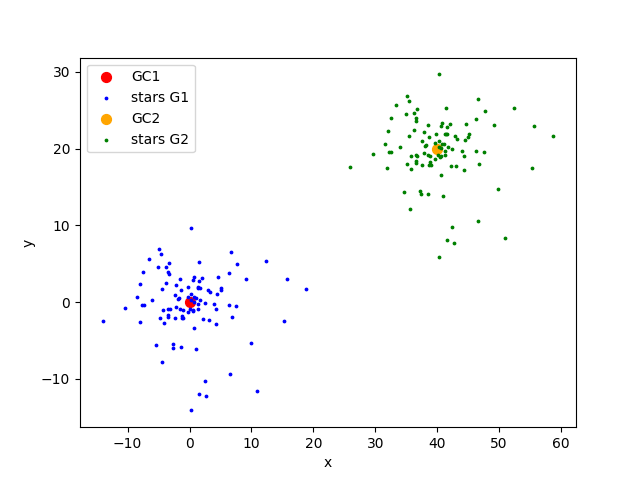

In [12]:
# we can visualize the two galaxies

import matplotlib.pyplot as plt
#from mpl_toolkits.mplot3d import Axes3D
#%matplotlib widget

fig = plt.figure()
plt.scatter(Galaxy1.pos[0,0], Galaxy1.pos[0,1], label='GC1', s=50, color='red')
plt.scatter(Galaxy1.pos[1:,0], Galaxy1.pos[1:,1], label='stars G1', s=3, color='blue')
plt.scatter(Galaxy2.pos[0,0], Galaxy2.pos[0,1], label='GC2', s=50, color='orange')
plt.scatter(Galaxy2.pos[1:,0], Galaxy2.pos[1:,1], label='stars G2', s=3, color='green')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='best')
plt.show()

# 1- Stability of the disc representation

A simulation of the galaxy in isolation was run to verify the stability of both the rotation curve and the disc surface density over a certain characteristic timescale. The characteristic timescale was estimated as the time required for the disc tracers to complete an orbit around the Galaxy. The average radius of the galaxy was used to calculate the period according to the $3^{rd}$ Kepler law. To visualize the rotation curve and the surface density profile of the galaxy, we converted the position of the galaxy, taking the galactic center as the origin of the system, into cylindrical coordinates.

## Rotation curve and Surface density profile
Let's plot the rotation curve and the surface density profile for one galaxy, in particular for Galaxy 1. 

The **rotation curve** of a galaxy shows the azimuthal velocity as function of the cylindrical radius . To estimate the azimuthal velocity for each particle we transform the Cartesian coordinates to cylindrical: 

$$
\begin{cases}
R_{\text{cyl}} = \sqrt(x^2+y^2) \\
\phi = \arctan(\frac{y}{x}) \\
z=z
\end{cases}
$$

We then computed the azymuthal velocity for all the particles using: 
$$
V_\phi = V_y \cdot \cos(\phi) - V_x\cdot \sin(\phi)
$$

We then plotted $V_\phi$ vs $R$ to obtain the rotation curve of the galaxy. 

The **surface density profile** $\Sigma$ shows the amount of mass in a cylindrical ring divided by the area of the ring. To estimate it we bin the particles on the cylindrical radius $R_{\text{cyl}}$, then we sum all the masses of the particles to obtain $M_{\text{tot, ring}}$ and then the area of the ring is given by $\pi (R^2_{\text{outer}}-R^2_{\text{inner}})$ where $R_{\text{inner}}$ and $R_{\text{outer}}$ are the borders of the considered bin. Finally $\Sigma_{\text{ring}}=M_{\text{tot, ring}}/A_{\text{ring}}$. 

We plotted the initial number suface density of the disc, which means that we use the number of particles instead of the total mass of the ring, as function of the cylindrical radius.

We developed some function to helps us to obtain the plots:
* `rotation_curve_rescaled`: takes as input the class and the particle we defined as the galactic center and outputs the cylindrical radius and the azimuthal velocity (rescaled to the galactic center);
* `surface_density`: computes the numerical surface density taking as input the cylindrical radius;
* `ìntegration_leapfrog_galaxy`: integrates the galaxy over the time of the simulation using the integrator leapfrog, moreover computes the cyclindrical radius and the azimuthal velocity using `rotation_curve_rescaled`.

---





In [8]:
from typing import Optional, Tuple, Callable, Union

def rotation_curve_rescaled(galaxy: Particles, GC: float):
    
    # rescale the position and velocity of the particles
    # GC is the particle assumed as the center of the galaxy
    '''
    dx = galaxy.pos[:,0] - galaxy.pos[GC,0]
    dy = galaxy.pos[:,1] - galaxy.pos[GC,1]
    dz = galaxy.pos[:,2] - galaxy.pos[GC,2]

    dvx = galaxy.vel[:,0] - galaxy.vel[GC,0]
    dvy = galaxy.vel[:,1] - galaxy.vel[GC,1]
    dvz = galaxy.vel[:,2] - galaxy.vel[GC,2]
    '''

    X = galaxy.pos[:,:] - galaxy.pos[GC,:]
    V = galaxy.vel[:,:] - galaxy.vel[GC,:]

    # compute the cylindrical radius and azimuthal angle
    Rcyl = np.sqrt(X[:,0]**2. + X[:,1]**2.)                # cylindrical radius
    phi = np.arctan2(X[:,1], X[:,0])                       # azimuthal angle
    Z = X[:,2]                                             # z-coordinate

    # compute velocities    
    vel_phi = V[:,1] * np.cos(phi) - V[:,0] * np.sin(phi) + V[:,2]      # azimuthal velocity
    vel_r = np.cos(phi) * V[:,0] + np.sin(phi) * V[:,1] + V[:,2]        # radial velocity
    vel_z = V[:,2]                                                      # vertical velocity

    return Rcyl, Z, vel_phi, vel_r, vel_z

def surface_density(Rcyl):
    H, edge = np.histogram(Rcyl, bins=20)                                          # histogram of the cylindrical radius
    area =  np.pi * (edge[1:]**2 - edge[0:-1]**2)                                  # area of every bin (every concentric ring) 
    mid = 0.5 * (edge[1:] + edge[0:-1])                                            # midpoint of every bin  

    return mid, H, area

In [9]:
def integration_leapfrog(galaxy: Particles, h: float, tsimulation: float, t: float, soft: float, GC: float):
    
    N = int((tsimulation - t) / h)              # number of time steps
    num_particles = len(galaxy.mass)            # number of particles in the galaxy
    '''
    path = np.empty((N, num_particles, 3))      # array to store the position of the galaxy
    velocity = np.empty((N, num_particles, 3))  # array to store the velocity of the galaxy
    time = np.empty(N)
    '''
    path = []
    velocity = []
    time = []
    
    R_cyl, _, V_phi, V_r, V_z = rotation_curve_rescaled(galaxy, GC)
    R_cyl = [R_cyl]
    V_phi = [V_phi]
    V_r = [V_r]
    V_z = [V_z]

    while t < tsimulation:
        galaxy, updated_acc, _, _ = integrator_leapfrog_galaxy(particles=galaxy, tstep=h, acceleration_estimator=acceleration_pyfalcon, softening=soft)
        path.append(galaxy.pos)
        velocity.append(galaxy.vel)
            
        R, z, Vphi, Vr, Vz = rotation_curve_rescaled(galaxy, GC)
        
        t = t + h
        time.append(t)

        R_cyl.append(R)
        V_phi.append(Vphi) 
        V_r.append(Vr)
        V_z.append(Vz)

    path = np.array(path)
    velocity = np.array(velocity)
    time = np.array(time)

    R_cyl = np.array(R_cyl)
    V_phi = np.array(V_phi)
    V_r = np.array(V_r)
    V_z = np.array(V_z)

    return path, velocity, time, R_cyl, V_phi, V_r, V_z

In [10]:
# compute the orbital period with T = 2*pi*sqrt(a^3/GM)

G = 1.                                                                   # gravitational constant in n-body units
plummer_scale_lenght = 5.                                                # scale lenght of the plummer sphere (softening)

radius = np.sqrt(np.sum((Galaxy1.pos-Galaxy1.pos[0])**2., axis=1))       # radius array

central_mass = Galaxy1.mass[0]                                           # central mass of the galaxy

T = 2 * np.pi * np.sqrt(radius**3 / (G * central_mass))                  # period of the galaxy using radius array  
T = np.mean(T)

print(f'Period of the galaxy (approximately): {T}')

# define the time of simulation and the number of steps

t0 = 0.                         # initial time
tsimulation = 1*T               # time of simulation (one period)
N = int(1e3)                    # number of steps
h = (tsimulation - t0)/N        # time steps

Galaxy1_test = Galaxy1.copy()

Galaxy1_orbit, Galaxy1_stars_vel, Galaxy1_time, Galaxy1_Rcyl, Galaxy1_Vphi, Galaxy1_Vr, Galaxy1_Vz = integration_leapfrog(galaxy=Galaxy1_test, h=h, 
                                                                                            tsimulation=tsimulation, t=t0, soft=plummer_scale_lenght, GC=0)

print(Galaxy1_orbit.shape)

Period of the galaxy (approximately): 98.32665772930324
(1001, 100, 3)


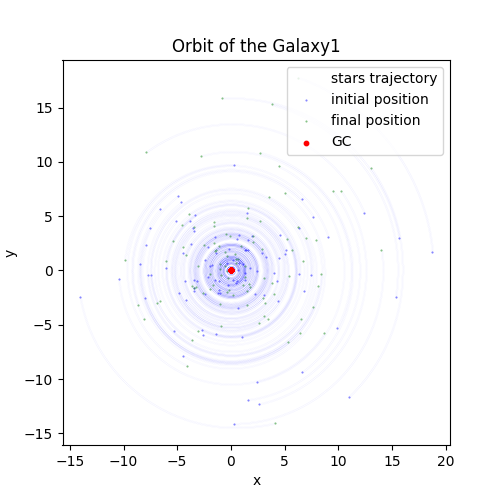

In [11]:
# plot the orbit of the galaxy
plt.figure(figsize=(5,5))
plt.scatter(Galaxy1_orbit[:,1:,0], Galaxy1_orbit[:,1:,1], s=0.05, color='b', label='stars trajectory', alpha=0.01)
plt.plot(Galaxy1_orbit[0,1:,0], Galaxy1_orbit[0,1:,1], 'o', markersize=0.5, c='b', label='initial position', alpha=0.5)
plt.plot(Galaxy1_orbit[-1,1:,0], Galaxy1_orbit[-1,1:,1], 'o', markersize=0.5, c='g', label='final position', alpha=0.5)
plt.scatter(Galaxy1_orbit[:,0,0], Galaxy1_orbit[:,0,1], s=10, color='r', label='GC', zorder=10)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Orbit of the Galaxy1')
plt.legend(loc='upper right')
plt.show()

### Rotation Curve and Density profile:


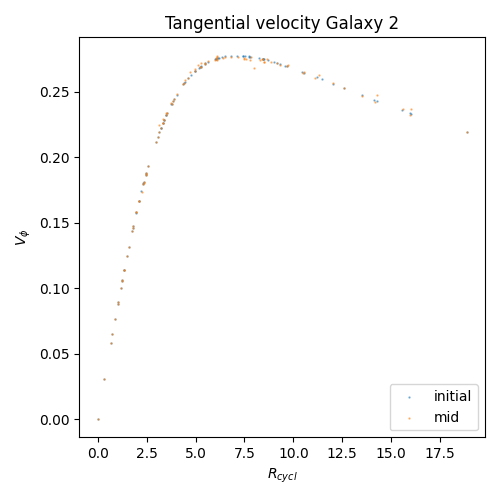

In [14]:
plt.figure(figsize=(5, 5))
n = Galaxy1_Rcyl.shape[0]
snapshots = np.arange(0, n, n//2)
title = ['initial', 'mid', 'final']
for i in range (len(snapshots)):
    plt.scatter(Galaxy1_Rcyl[snapshots[i],:], Galaxy1_Vphi[snapshots[i],:], s=0.5, label=title[i], alpha=0.5)
    
plt.xlabel('$R_{cycl}$')
plt.ylabel('$V_{\phi}$')
plt.title('Tangential velocity Galaxy 2')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()  

In [16]:
# intial surface density
mid, H, area = surface_density(Galaxy1_Rcyl[0])

# final surface density
mid_end, H_end, area_end = surface_density(Galaxy1_Rcyl[-1])

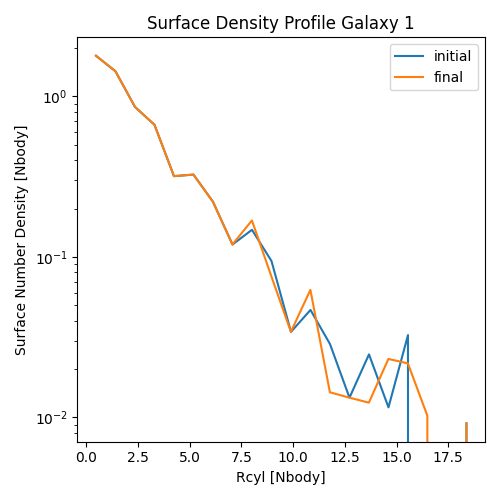

In [18]:
# plot the surface density of the initial and final galaxy
plt.figure(figsize=(5,5))
plt.plot(mid, H / area, label='initial')
plt.plot(mid_end, H_end / area_end, label='final')
plt.yscale('log')
plt.xlabel("Rcyl [Nbody]")  
plt.ylabel("Surface Number Density [Nbody]")
plt.title("Surface Density Profile Galaxy 1")
plt.legend()
plt.tight_layout()
plt.show()

Here we can see that the *Rotation Curve* remains stable for all the simulation time (1 galaxy period) and the surface density profile...

---

# 2 - Galaxy encounter

We run a galaxy encounter and then show how the rotation curve and the disc surface profile evolve with time. 
First of all, we make a single class with both galaxies. 

In [19]:
# Combine Galaxy1 and Galaxy2 into a single Particles class
combined_pos = np.concatenate((Galaxy1.pos, Galaxy2.pos))
combined_vel = np.concatenate((Galaxy1.vel, Galaxy2.vel))
combined_mass = np.concatenate((Galaxy1.mass, Galaxy2.mass))

Combined_Galaxies = Particles(combined_pos, combined_vel, combined_mass)

div = int(num_particles) # first index of the second galaxy

We define another function for the integration `integration_leapfrog_encounter` to differentiate the rescaling for the two galaxies based on the ID of the particles. 

In [22]:
def integration_leapfrog_encounter(galaxy: Particles, h: float, tsimulation: float, t: float, soft: float):
    N = int((tsimulation - t) / h)  # number of time steps
    '''
    num_particles = len(galaxy.mass)  # number of particles in the galaxy
    path = np.empty((N, num_particles, 3))  # array to store the position of the galaxy
    velocity = np.empty((N, num_particles, 3))  # array to store the velocity of the galaxy
    time = np.empty(N)
    '''
    path = []
    velocity = []
    time = []
    
    R_cyl, _, V_phi, V_r, V_z = rotation_curve_rescaled(galaxy, GC=np.where(galaxy.ID < (len(galaxy.ID)//2), 0, len(galaxy.ID)//2))
    R_cyl = [R_cyl]
    V_phi = [V_phi]
    V_r = [V_r]
    V_z = [V_z]

    while t < tsimulation:
        galaxy, updated_acc, _, _ = integrator_leapfrog_galaxy(particles=galaxy, tstep=h, acceleration_estimator=acceleration_pyfalcon, softening=soft)
        path.append(galaxy.pos)
        velocity.append(galaxy.vel)
            
        R, z, Vphi, Vr, Vz = rotation_curve_rescaled(galaxy, GC=np.where(galaxy.ID < (len(galaxy.ID)//2), 0, len(galaxy.ID)//2))

        t += h
        time.append(t)

        R_cyl.append(R)
        V_phi.append(Vphi) 
        V_r.append(Vr)
        V_z.append(Vz)

    path = np.array(path)
    velocity = np.array(velocity)
    time = np.array(time)

    R_cyl = np.array(R_cyl)
    V_phi = np.array(V_phi)
    V_r = np.array(V_r)
    V_z = np.array(V_z)

    return path, velocity, time, R_cyl, V_phi, V_r, V_z

In [23]:
# just keep the same tsimulation and N as before
G = 1.                                                                   # gravitational constant in n-body units
T_sim = 4*T         #210
plummer_scale_lenght = 5.                                                # scale lenght of the plummer sphere (softening)
t0 = 0.
tsimulation = T_sim
N = int(1e3)
h = (tsimulation - t0)/N

Combined_Galaxies_test = Combined_Galaxies.copy()

Combined_Galaxies_orbit, Combined_Galaxies_stars_vel, Combined_Galaxies_time, Combined_Galaxies_Rcyl, Combined_Galaxies_Vphi, Combined_Galaxies_Vr, Combined_Galaxies_Vz = integration_leapfrog_encounter(galaxy=Combined_Galaxies_test, h=h, 
                                                                                                                                                                            tsimulation=tsimulation, t=t0, soft=plummer_scale_lenght)

### Plot of the whole evolution
We make a plot showing the whole evolution of the galaxies, namely the trajectories of the trackers and of the galactic centers. We display even the initial and final positions of the galaxies. 

In [41]:
def plot_encounter_image(Galaxies: np.array, div: int):
    """
    :Galaxies: array containing the position of the galaxies and the GCs
    :div: index of the first and second Galactic center
    """

    plt.figure(figsize=(8,8))

    # stars trajectory
    plt.scatter(Galaxies[:,1:div,0], Galaxies[:,1:div,1], s=0.005, color='lightblue',  alpha=0.05)
    plt.scatter(Galaxies[:,(div+1):,0],  Galaxies[:,(div+1):,1],  s=0.005, color='lightgreen', alpha=0.05)

    # initial and final position of galaxy 1
    plt.plot(Galaxies[0,1:div,0],  Galaxies[0,1:div,1],  'o', markersize=2, c='cornflowerblue', label='initial position of Gal1', alpha=0.3)
    plt.plot(Galaxies[-1,1:div,0], Galaxies[-1,1:div,1], '*', markersize=3, c='b', label='final position of Gal1',   alpha=0.3)

    # initial and final position of galaxy 2
    plt.plot(Galaxies[0,(div+1):,0],  Galaxies[0,(div+1):,1],  'o', markersize=2, c='limegreen', label='initial position of Gal2', alpha=0.3)
    plt.plot(Galaxies[-1,(div+1):,0], Galaxies[-1,(div+1):,1], '*', markersize=3, c='g', label='final position of Gal2',   alpha=0.3)

    # initial and final position of GC1
    plt.plot(Galaxies[0,0,0],  Galaxies[0,0,1],  'o', markersize=4, color='r', label='GC 1', zorder=10)
    plt.plot(Galaxies[-1,0,0], Galaxies[-1,0,1], 'o', markersize=4, color='r',               zorder=10)

    # initial and final position of GC2
    plt.plot(Galaxies[0,div,0],  Galaxies[0,div,1],  'o', markersize=4, color='orange', label='GC 2', zorder=10)
    plt.plot(Galaxies[-1,div,0], Galaxies[-1,div,1], 'o', markersize=4, color='orange',               zorder=10)

    # trajectory of GC1
    plt.scatter(Galaxies[:,0,0],    Galaxies[:,0,1],    s=0.05, color='r',      zorder=10, alpha=0.5)
    # trajectory of GC2
    plt.scatter(Galaxies[:,div,0], Galaxies[:,div,1], s=0.05, color='orange', zorder=10, alpha=0.5)

    plt.xlabel('X [Nbody]')
    plt.ylabel('Y [Nbody]')
    plt.title('Galaxies Encounter')
    plt.legend(loc='lower right', fontsize=8)
    plt.grid(True, alpha=0.5)
    plt.show()
    

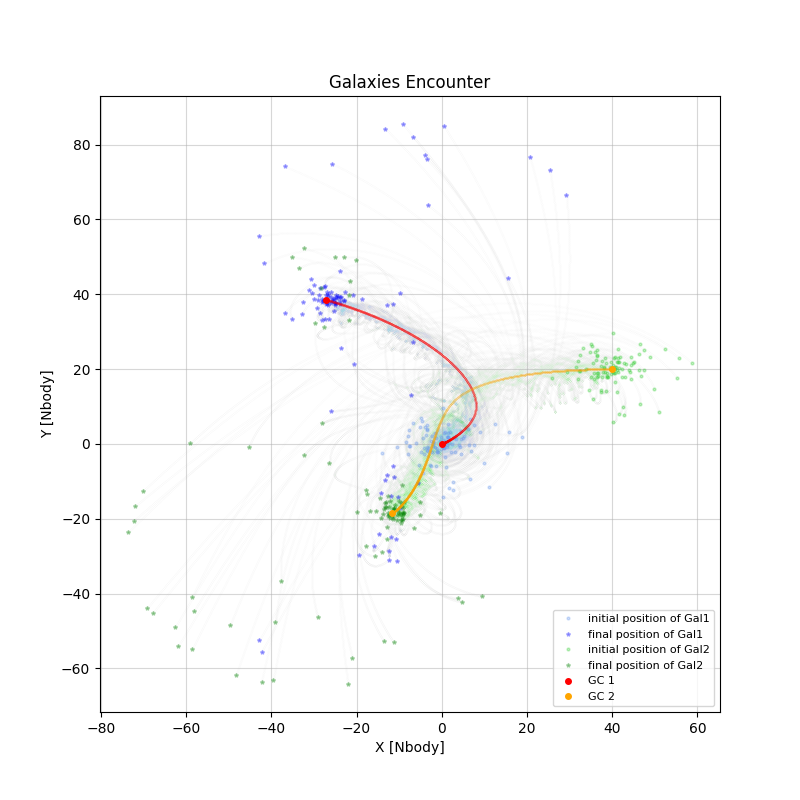

In [40]:
# Plot the encounter
plot_encounter_image(Combined_Galaxies_orbit, div)

### Final situation
We make a plot showing the final configuration of the galaxies after the encounter, the evolution of the rotation curve and the evolution of the surface density profile.  

In [51]:
# intial surface density G1
mid_in_1, H_in_1, area_in_1 = surface_density(Combined_Galaxies_Rcyl[0,:div])

# final surface density G1
mid_end_1, H_end_1, area_end_1 = surface_density(Combined_Galaxies_Rcyl[-1,:div])

# intial surface density G2 
mid_in_2, H_in_2, area_in_2 = surface_density(Combined_Galaxies_Rcyl[0,div:])

# final surface density G2
mid_end_2, H_end_2, area_end_2 = surface_density(Combined_Galaxies_Rcyl[-1,div:])

surface_density_G1 = ((mid_in_1, H_in_1, area_in_1),(mid_end_1, H_end_1, area_end_1))
surface_density_G2 = ((mid_in_2, H_in_2, area_in_2),(mid_end_2, H_end_2, area_end_2))

Combine_surface_densities = (surface_density_G1, surface_density_G2)

print(surface_density_G1[0][1])
print(type(surface_densities[0][0][1]))


[ 5 12 12 13  8 10  8  5  7  5  2  3  2  1  2  1  3  0  0  1]
<class 'numpy.ndarray'>


### Final plots after the encounter
Let's make a single plot containing the final situation of the galaxies, the evolution of their rotation curve and the one of their surface density. 

In [52]:
def encounter_result(Galaxies: np.array, div: int, Galaxies_Rcyl: np.array, Galaxies_Vphi: np.array, Surface_Densities: Tuple[Tuple[Tuple[np.array, np.array, np.array], 
                                                                                                                            Tuple[np.array, np.array, np.array]], 
                                                                                                                            Tuple[Tuple[np.array, np.array, np.array], 
                                                                                                                            Tuple[np.array, np.array, np.array]]]):
    """
    Galaxy: array containing the position of the galaxies and the GCs
    div: index of the first and second Galactic center
    Galaxies_Rcyl: array containing the cylindrical radius of the galaxies
    Galaxies_Vphi: array containing the azimuthal velocity of the galaxies
    Surface_Densities: tuple containing the surface density of the galaxies
    """
    
    plt.subplots(3,3,figsize=(12,12))

    plt.subplot(3, 3, 1)
    # final position of galaxy 1
    plt.plot(Galaxies[-1,1:div,0], Galaxies[-1,1:div,1], 'o', markersize=1, c='b', label='final position of Gal1',   alpha=0.5)
    # position of GC1
    plt.plot(Galaxies[-1,0,0], Galaxies[-1,0,1], 'o', markersize=4, color='r', label='GC 1', zorder=10)
    # final position of galaxy 2
    plt.plot(Galaxies[-1,(div+1):,0], Galaxies[-1,(div+1):,1], 'o', markersize=1, c='g', label='final position of Gal2',   alpha=0.5)
    # position of GC2
    plt.plot(Galaxies[-1,div,0], Galaxies[-1,div,1], 'o', markersize=4, color='orange', label='GC 2', zorder=10)

    plt.xlabel('X [Nbody]')
    plt.ylabel('Y [Nbody]')
    plt.title('Final position of the Galaxies')
    plt.legend(loc='lower right', fontsize=8)

    plt.subplot(3, 3, 2)
    # final position of galaxy 1
    plt.plot(Galaxies[-1,1:div,0], Galaxies[-1,1:div,1], 'o', markersize=1, c='b', label='final position of Gal1',   alpha=0.5)
    # position of GC1
    plt.plot(Galaxies[-1,0,0], Galaxies[-1,0,1], 'o', markersize=4, color='r', label='GC 1', zorder=10)

    plt.xlabel('X [Nbody]')
    plt.ylabel('Y [Nbody]')
    plt.title('Galaxy 1')
    plt.legend(loc='lower right', fontsize=8)

    plt.subplot(3, 3, 3)
    # final position of galaxy 2   
    plt.plot(Galaxies[-1,(div+1):,0], Galaxies[-1,(div+1):,1], 'o', markersize=1, c='g', label='final position of Gal2',   alpha=0.5)
    # position of GC2
    plt.plot(Galaxies[-1,div,0], Galaxies[-1,div,1], 'o', markersize=4, color='orange', label='GC 2', zorder=10)

    plt.xlabel('X [Nbody]')
    plt.ylabel('Y [Nbody]')
    plt.title('Galaxy 2')
    plt.legend(loc='lower right', fontsize=8)

    plt.subplot(3, 3, 5)
    plt.scatter(Galaxies_Rcyl[-1,1:div], Galaxies_Vphi[-1,1:div], s=0.5, color='r', label='final', alpha=0.5)
    plt.scatter(Galaxies_Rcyl[0,1:div], Galaxies_Vphi[0,1:div], s=0.5, color='b', label='initial', alpha=0.5)
    plt.legend(loc='best', fontsize=8)
    plt.xlabel('$R_{cycl}$')
    plt.ylabel('$V_{\phi}$')
    plt.title('Rotation curve Galaxy 1')

    plt.subplot(3, 3, 6)
    plt.scatter(Galaxies_Rcyl[-1,(div+1):], Galaxies_Vphi[-1,(div+1):], s=0.5, color='g', label='final', alpha=0.5)
    plt.scatter(Galaxies_Rcyl[0,(div+1):], Galaxies_Vphi[0,(div+1):], s=0.5, color='b', label='initial', alpha=0.5)
    plt.legend(loc='best', fontsize=8)
    plt.xlabel('$R_{cycl}$')
    plt.ylabel('$V_{\phi}$')
    plt.title('Rotation curve Galaxy 2')

    plt.subplot(3, 3, 4)
    plt.scatter(Galaxies_Rcyl[-1,1:div], Galaxies_Vphi[-1,1:div], s=0.5, color='r', label='final G1', alpha=0.5)
    plt.scatter(Galaxies_Rcyl[-1,(div+1):], Galaxies_Vphi[-1,(div+1):], s=0.5, color='g', label='final G2', alpha=0.5)
    plt.scatter(Galaxies_Rcyl[0,1:div], Galaxies_Vphi[0,1:div], s=0.5, color='b', label='initial G1 and G2', alpha=0.5)
    plt.legend(loc='best', fontsize=8)
    plt.xlabel('$R_{cycl}$')
    plt.ylabel('$V_{\phi}$')
    plt.title('Rotation curve (G1 and G2)')

    mid_in_1, H_in_1, area_in_1 = Surface_Densities[0][0]
    mid_end_1, H_end_1, area_end_1 = Surface_Densities[0][1]
    mid_in_2, H_in_2, area_in_2 = Surface_Densities[1][0]
    mid_end_2, H_end_2, area_end_2 = Surface_Densities[1][1]

    plt.subplot(3, 3, 7)
    plt.plot(mid_in_1, H_in_1 / area_in_1, label='initial G1 and G2', c='b')
    plt.plot(mid_end_1, H_end_1 / area_end_1, label='final G1', c='r')
    plt.plot(mid_end_2, H_end_2 / area_end_2, label='final G2', c='g')
    plt.yscale('log')
    plt.xlabel("Rcyl [Nbody]")  
    plt.ylabel("Surface Number Density [Nbody]")
    plt.legend(loc='best', fontsize=8)
    plt.title("Surface Density Profile (G1 and G2)")

    plt.subplot(3, 3, 8)
    plt.plot(mid_in_1, H_in_1 / area_in_1, label='initial', c='b')
    plt.plot(mid_end_1, H_end_1 / area_end_1, label='final', c='r')
    plt.yscale('log')
    plt.xlabel("Rcyl [Nbody]")  
    plt.ylabel("Surface Number Density [Nbody]")
    plt.legend(loc='best', fontsize=8)
    plt.title("Surface Density Profile Galaxy 1")

    plt.subplot(3, 3, 9)
    plt.plot(mid_in_2, H_in_2 / area_in_2, label='initial', c='b')
    plt.plot(mid_end_2, H_end_2 / area_end_2, label='final', c='g')
    plt.yscale('log')
    plt.xlabel("Rcyl [Nbody]")  
    plt.ylabel("Surface Number Density [Nbody]")
    plt.legend(loc='best', fontsize=8)
    plt.title("Surface Density Profile Galaxy 2")


    plt.tight_layout()
    plt.show()

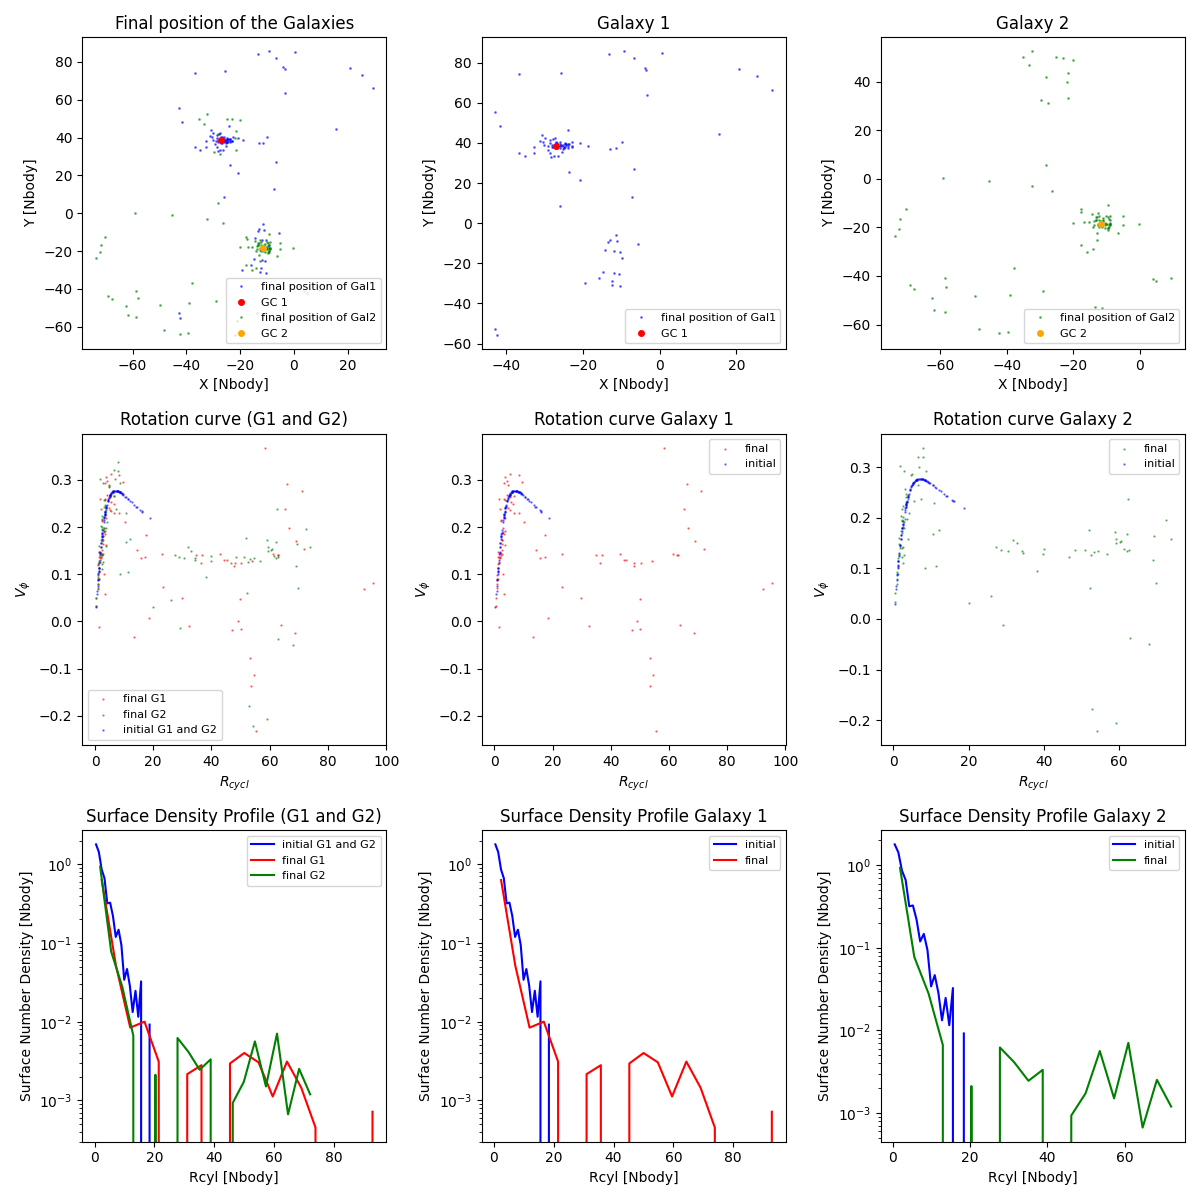

In [53]:
encounter_result(Combined_Galaxies_orbit, div, Combined_Galaxies_Rcyl, Combined_Galaxies_Vphi, surface_densities)

### Evolution of radial and vertical velocity

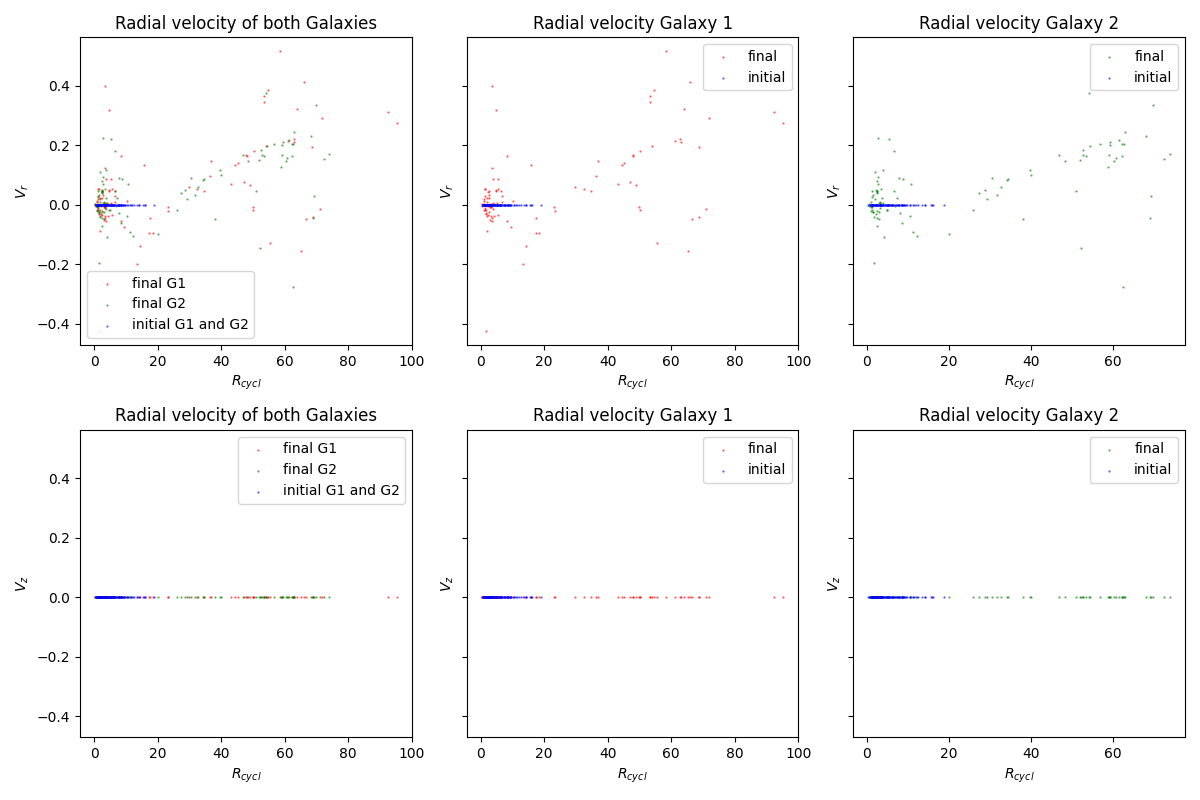

In [70]:
def Radial_Vertical_velocity(Galaxies_Rcyl: np.array, Galaxies_Vr: np.array, Galaxies_Vz: np.array, div: int):
    """
    Galaxies_Rcyl: array containing the cylindrical radius of the galaxies
    Galaxy1_Vr: array containing the azimuthal velocity of the galaxies
    Galaxy1_Vz: array containing the vertical velocity of the galaxies
    div: index of the first and second Galactic center
    """
    plt.subplots(2,3,figsize=(12,8), sharey=True)

    plt.subplot(2, 3, 2)
    plt.scatter(Galaxies_Rcyl[-1,1:div], Galaxies_Vr[-1,1:div], s=0.5, color='r', label='final', alpha=0.5)
    plt.scatter(Galaxies_Rcyl[0,1:div], Galaxies_Vr[0,1:div], s=0.5, color='b', label='initial', alpha=0.5)
    plt.legend(loc='best')
    plt.xlabel('$R_{cycl}$')
    plt.ylabel('$V_{r}$')
    plt.title('Radial velocity Galaxy 1')

    plt.subplot(2, 3, 3)
    plt.scatter(Galaxies_Rcyl[-1,(div+1):], Galaxies_Vr[-1,(div+1):], s=0.5, color='g', label='final', alpha=0.5)
    plt.scatter(Galaxies_Rcyl[0,(div+1):], Galaxies_Vr[0,(div+1):], s=0.5, color='b', label='initial', alpha=0.5)
    plt.legend(loc='best')
    plt.xlabel('$R_{cycl}$')
    plt.ylabel('$V_{r}$')
    plt.title('Radial velocity Galaxy 2')

    plt.subplot(2, 3, 1)
    plt.scatter(Galaxies_Rcyl[-1,1:div], Galaxies_Vr[-1,1:div], s=0.5, color='r', label='final G1', alpha=0.5)
    plt.scatter(Galaxies_Rcyl[-1,(div+1):], Galaxies_Vr[-1,(div+1):], s=0.5, color='g', label='final G2', alpha=0.5)
    plt.scatter(Galaxies_Rcyl[0,1:div], Galaxies_Vr[0,1:div], s=0.5, color='b', label='initial G1 and G2', alpha=0.5)
    plt.legend(loc='best')
    plt.xlabel('$R_{cycl}$')
    plt.ylabel('$V_{r}$')
    plt.title('Radial velocity of both Galaxies')

    plt.subplot(2, 3, 5)
    plt.scatter(Galaxies_Rcyl[-1,1:div], Galaxies_Vz[-1,1:div], s=0.5, color='r', label='final', alpha=0.5)
    plt.scatter(Galaxies_Rcyl[0,1:div], Galaxies_Vz[0,1:div], s=0.5, color='b', label='initial', alpha=0.5)
    plt.legend(loc='best')
    plt.xlabel('$R_{cycl}$')
    plt.ylabel('$V_{z}$')
    plt.title('Radial velocity Galaxy 1')

    plt.subplot(2, 3, 6)
    plt.scatter(Galaxies_Rcyl[-1,(div+1):], Galaxies_Vz[-1,(div+1):], s=0.5, color='g', label='final', alpha=0.5)
    plt.scatter(Galaxies_Rcyl[0,(div+1):], Galaxies_Vz[0,(div+1):], s=0.5, color='b', label='initial', alpha=0.5)
    plt.legend(loc='best')
    plt.xlabel('$R_{cycl}$')
    plt.ylabel('$V_{z}$')
    plt.title('Radial velocity Galaxy 2')

    plt.subplot(2, 3, 4)
    plt.scatter(Galaxies_Rcyl[-1,1:div], Galaxies_Vz[-1,1:div], s=0.5, color='r', label='final G1', alpha=0.5)
    plt.scatter(Galaxies_Rcyl[-1,(div+1):], Galaxies_Vz[-1,(div+1):], s=0.5, color='g', label='final G2', alpha=0.5)
    plt.scatter(Galaxies_Rcyl[0,1:div], Galaxies_Vz[0,1:div], s=0.5, color='b', label='initial G1 and G2', alpha=0.5)
    plt.legend(loc='best')
    plt.xlabel('$R_{cycl}$')
    plt.ylabel('$V_{z}$')
    plt.title('Radial velocity of both Galaxies')

    plt.tight_layout()
    plt.show()

Radial_Vertical_velocity(Combined_Galaxies_Rcyl, Combined_Galaxies_Vr, Combined_Galaxies_Vz, div)

While the radial velocity changes, the vertical velocity remains zero meaning that the trackers are moving only in a plane. 

---

# Counter-rotating galaxies

In [57]:
# invert the velocity of the first galaxy
Combined_Galaxies_counter = Combined_Galaxies.copy()
Combined_Galaxies_counter.vel[1:div] = -Combined_Galaxies_counter.vel[1:div]

In [58]:
# just keep the same tsimulation and N as before
G = 1.                                                                   # gravitational constant in n-body units
T_sim = 4*T
plummer_scale_lenght = 5.                                                # scale lenght of the plummer sphere (softening)
t0 = 0.
tsimulation = T_sim
N = int(1e3)
h = (tsimulation - t0)/N

Counter_Galaxies_test = Combined_Galaxies_counter.copy()

Counter_Galaxies_orbit, Counter_Galaxies_stars_vel, Counter_Galaxies_time, Counter_Galaxies_Rcyl, Counter_Galaxies_Vphi, Counter_Galaxies_Vr, Counter_Galaxies_Vz = integration_leapfrog_encounter(galaxy=Counter_Galaxies_test, h=h, 
                                                                                                                                                                            tsimulation=tsimulation, t=t0, soft=plummer_scale_lenght)

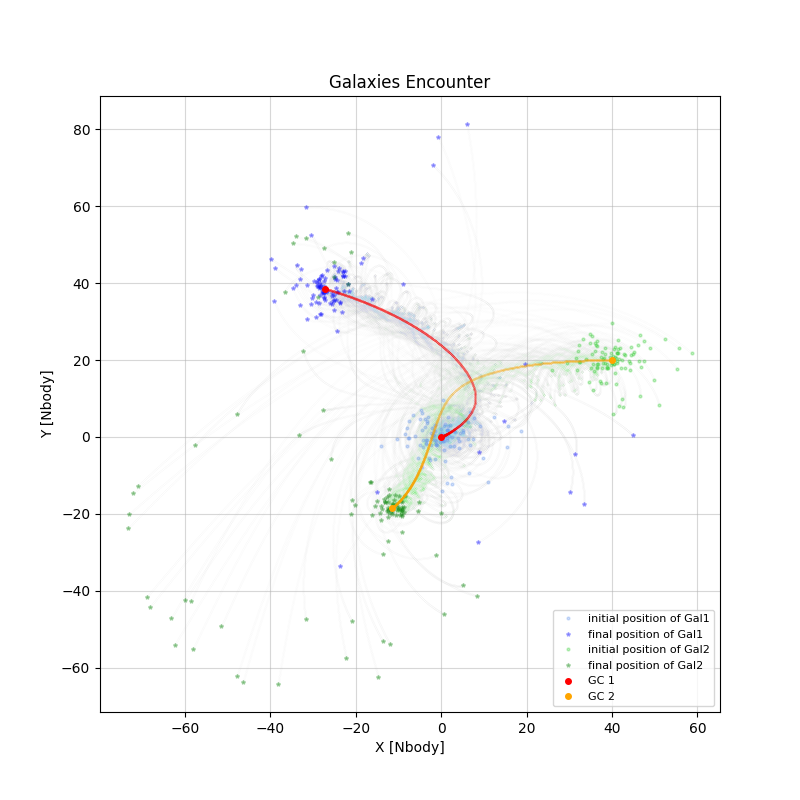

In [59]:
# Plot the encounter
plot_encounter_image(Counter_Galaxies_orbit, div)

In [60]:
# intial surface density G1
mid_c_in_1, H_c_in_1, area_c_in_1 = surface_density(Counter_Galaxies_Rcyl[0,:div])

# final surface density G1
mid_c_end_1, H_c_end_1, area_c_end_1 = surface_density(Counter_Galaxies_Rcyl[-1,:div])

# intial surface density G2 
mid_c_in_2, H_c_in_2, area_c_in_2 = surface_density(Counter_Galaxies_Rcyl[0,div:])

# final surface density G2
mid_c_end_2, H_c_end_2, area_c_end_2 = surface_density(Counter_Galaxies_Rcyl[-1,div:])

surface_density_G1_c = ((mid_c_in_1, H_c_in_1, area_c_in_1),(mid_c_end_1, H_c_end_1, area_c_end_1))
surface_density_G2_c = ((mid_c_in_2, H_c_in_2, area_c_in_2),(mid_c_end_2, H_c_end_2, area_c_end_2))
surface_densities_c = (surface_density_G1_c, surface_density_G2_c)

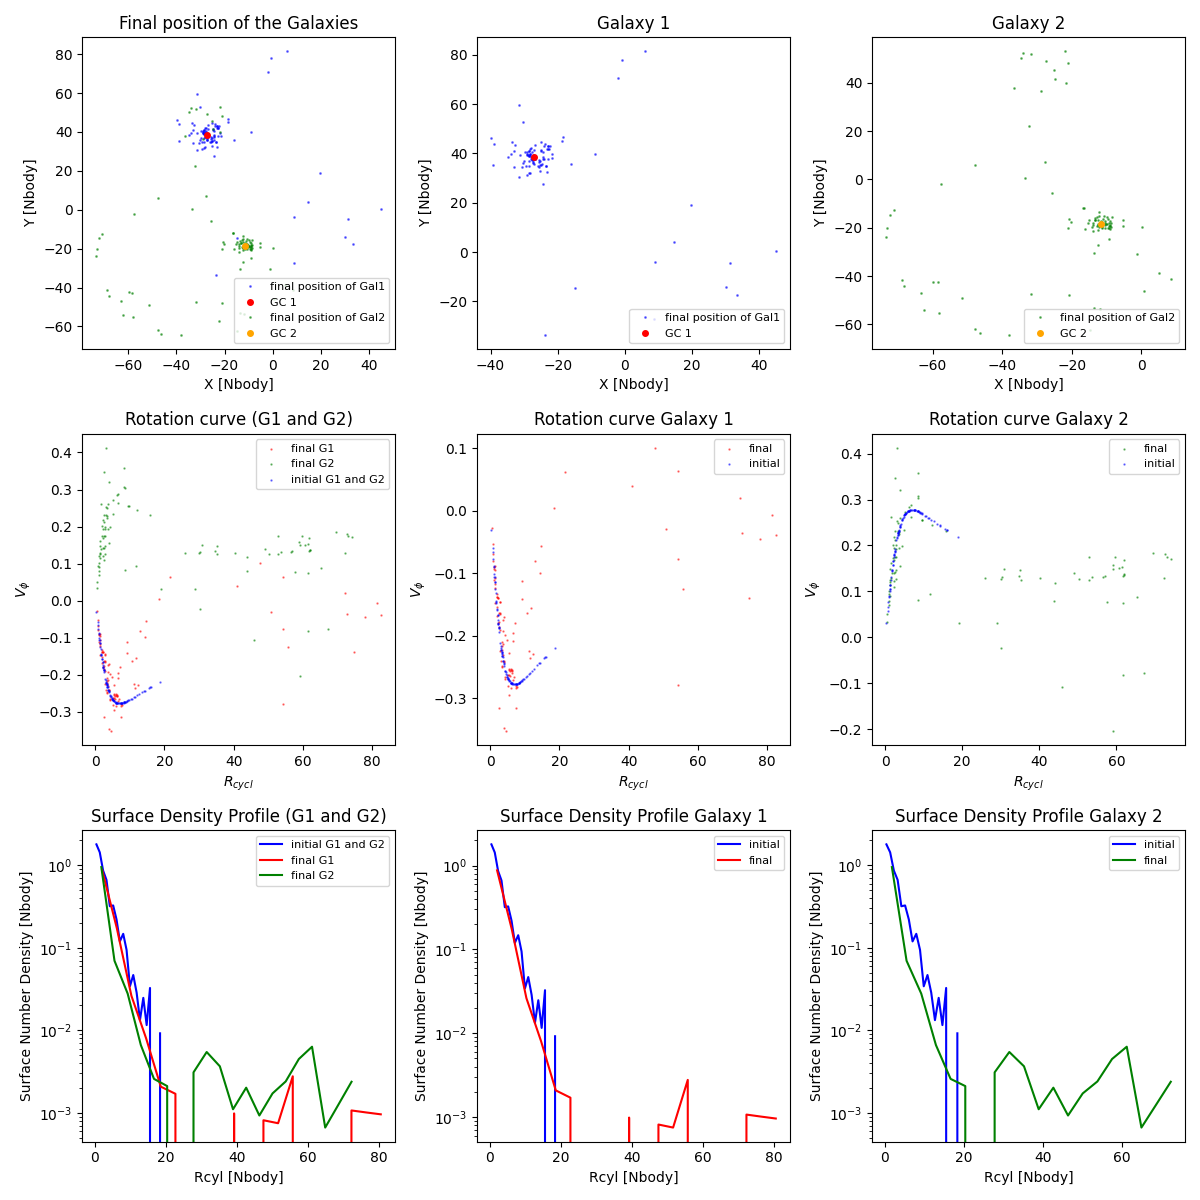

In [61]:
encounter_result(Counter_Galaxies_orbit, div, Counter_Galaxies_Rcyl, Counter_Galaxies_Vphi, surface_densities_c)

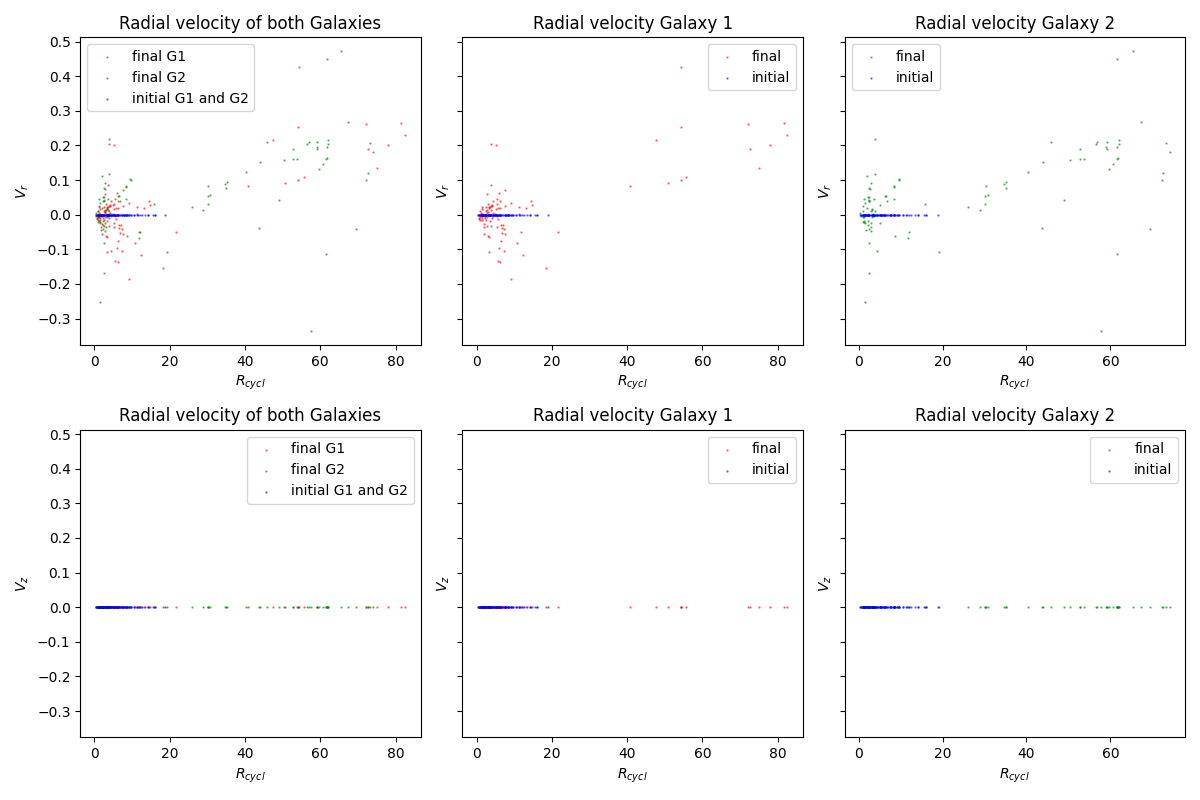

In [72]:
# plot the Radial Velocity and Vertical Velocity

Radial_Vertical_velocity(Counter_Galaxies_Rcyl, Counter_Galaxies_Vr, Counter_Galaxies_Vz, div)

---

# Inclined encounter